##Objective
###### Modularize the code into python files for RESNET-18 architecture on CIFAR-10 dataset with implementation of GradCAM

##Import Packages
##### Python libraries required for CIFAR10

In [1]:
pip install albumentations==0.4.5

     |████████████████████████████████| 122kB 8.8MB/s 
     |████████████████████████████████| 634kB 51.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=8f394c79948eb264831e8647a90f94725a9291ad1a97c299838f57d029d2307c
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=20826fef3784054017a75c8691baf9b81172dc7dca4ef1b0e14cc547fc8379f4
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [0]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import PIL
import numpy as np

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchsummary import summary

###### Packages from Modules 

In [4]:
from train import train
from test import test
from data import CIFAR10
from cuda import initialze_cuda
from lr_finder import LRFinder
from resnet import ResNet18
from gradcam_utils import _GradCAM
from plot import Plot

  pip install torch-lr-finder -v --global-option="amp"


##Initialize Cuda
##### Set up the seed value for the machine

In [5]:
cuda, device = initialze_cuda(1)

Is CUDA Available? True


## Initialize Hyperparameters
##### Assigning various parameters required by the dataset and model

In [0]:
class Args:
    
    cuda = cuda
    batch_size = 64
    num_workers = 4
    horizontal_flip = 0.2
    vertical_flip = 0.1
    rotation = 10
    cutout = 0.3
    gaussian_blur = 0.1
    
    learning_rate = 0.01
    momentum = 0.9
    lr_step = 25
    lr_gamma = 0.1
    epochs = 5
    sample_count = 25

    start_lr = 1e-7
    end_lr = 1
    lr_num_iter = 400

###Intialize CIFAR-10 dataset

In [7]:
cifar10 = CIFAR10(cuda= Args.cuda,
                  batch_size = Args.batch_size,
                  num_workers = Args.num_workers,
                  horizontal_flip = Args.horizontal_flip, 
                  vertical_flip = Args.vertical_flip, 
                  rotation = Args.rotation,
                  cutout = Args.cutout,
                  gaussian_blur = Args.gaussian_blur)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


##Visualizing images from the CIFAR-10 Dataset
##### These images can help one realise which image augmentation techniques are the best for the given dataset

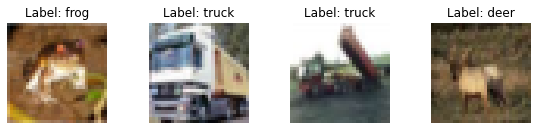

In [8]:
classes = cifar10.classes
sample_data, sample_targets = cifar10.data

#Dimension of the data
_ ,height,width,channels = sample_data.shape

# Set number of images to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(1, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(num_images):
    axs[i].axis('off')
    axs[i].set_title(f'Label: {classes[sample_targets[i]]}')
    axs[i].imshow(sample_data[i])

###Load data on Dataloader

In [0]:
train_loader = cifar10.dataloader(train = True)
test_loader = cifar10.dataloader(train = False)

##Architecture 
#####Load the model architecture on the device 
#####Summary of the Architecture

In [10]:
model = ResNet18().to(device)
summary(model, cifar10.input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

###LR_finder
Provides the initial best Learning rate based on findings of Leslie Smith

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=Args.start_lr, momentum=Args.momentum)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=Args.end_lr, num_iter=Args.lr_num_iter, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


Initial Learning rate:  0.015135612484362078
Loss:  1.8591121633450738


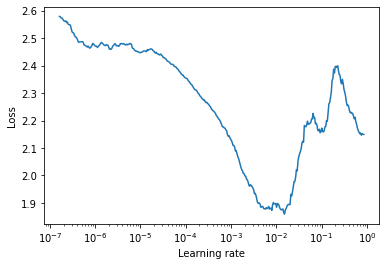

In [17]:
_, initial_learning_rate = lr_finder.plot()
lr_finder.reset()

##Model Training and Validation

In [20]:
losses = []
accuracies = []
correct_samples = []
incorrect_samples= []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=initial_learning_rate, momentum=Args.momentum)
#scheduler = StepLR(optimizer, Args.lr_step, Args.lr_gamma)
scheduler = ReduceLROnPlateau(optimizer,mode='min',patience=4,verbose=True)
epochs = Args.epochs
last_epoch = False


for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    if epoch == epochs:
        last_epoch = True
    train(model, train_loader, device, optimizer, criterion)
    #scheduler.step()
    val_loss = test(model, test_loader, device, criterion, losses, accuracies, correct_samples, 
         incorrect_samples, last_epoch, Args.sample_count)
    scheduler.step(val_loss)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0175, Accuracy: 6019/10000 (60.19%)

Epoch 2:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0131, Accuracy: 7072/10000 (70.72%)

Epoch 3:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0132, Accuracy: 7121/10000 (71.21%)

Epoch 4:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0116, Accuracy: 7485/10000 (74.85%)

Epoch 5:


Loss=0.63 Batch ID=781 Accuracy=78.28: 100%|██████████| 782/782 [00:30<00:00, 25.29it/s]



Validation set: Average loss: 0.0089, Accuracy: 8055/10000 (80.55%)



##GradCAM

#####Load the image

In [0]:
img_path = '/content/water-bird.JPEG'
pil_img = PIL.Image.open(img_path)

###Process the Image

In [0]:
args={'mean' : cifar10.mean,
        'std': cifar10.std,
        'height' :cifar10.input_size[1],
        'width' : cifar10.input_size[2],
        'device' : device
}
        
grad_cam = _GradCAM(**args)
image = grad_cam.preprocess_image(pil_img)

###GradCam result

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


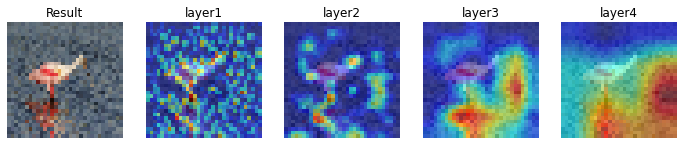

In [23]:
args = {'model':model,
        'layer_name' : ['layer1', 'layer2', 'layer3', 'layer4'],
        'input' : image
}

grad_cam.gradcam(** args)

###Plotting the loss of the model per epoch

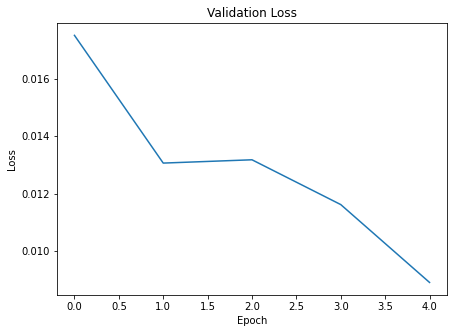

In [24]:
plot = Plot(cifar10.mean, cifar10.std, device)

plot.plot_metric(losses, 'Loss')

###Plotting the accuracy of the model per epoch

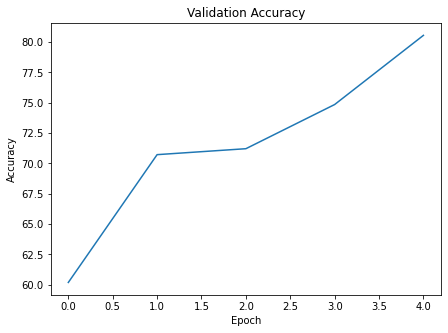

In [25]:
plot.plot_metric(accuracies, 'Accuracy')

###Correct Prediction

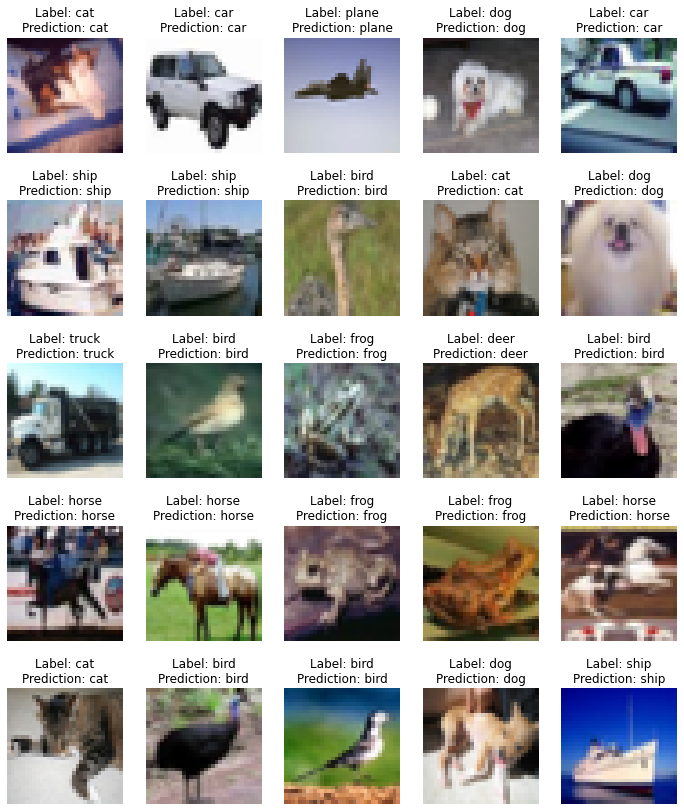

In [26]:
plot.plot_images(correct_samples, cifar10.classes, 'Correct_samples')

###Incorrect Prediction

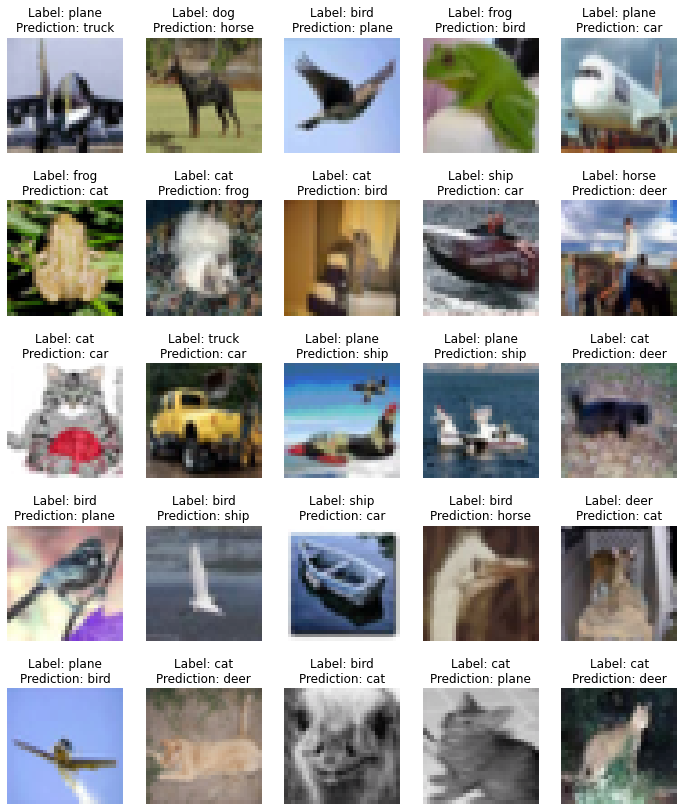

In [27]:
plot.plot_images(incorrect_samples, cifar10.classes, 'Incorrect_samples')

###Accuracy of each class of the dataset

In [28]:
plot.class_accuracy(model, cifar10.classes, test_loader)

Accuracy of plane : 74.3% 	 Image count: 1000
Accuracy of car : 96.0% 	 Image count: 1000
Accuracy of bird : 72.5% 	 Image count: 1000
Accuracy of cat : 67.5% 	 Image count: 1000
Accuracy of deer : 80.5% 	 Image count: 1000
Accuracy of dog : 70.3% 	 Image count: 1000
Accuracy of frog : 87.2% 	 Image count: 1000
Accuracy of horse : 89.2% 	 Image count: 1000
Accuracy of ship : 93.7% 	 Image count: 1000
Accuracy of truck : 74.3% 	 Image count: 1000
